# Mixture Modeling

The idea in this case is to treat a single time-interval of urban growth as an unsupervised learning problem in which we aim to learn the mixture density giving the settlement likelihoods. 

One limitation of this model is that there are many more parameters to learn unless we impose a hard thresholding scheme for parameter-sharing. Another limitation is that it is much harder to learn explicitly from time-series. 

In [1]:
import numpy as np
from urban_growth.mixture_model import *
from matplotlib import pyplot as plt
from scipy.spatial import distance
%matplotlib inline

In [16]:
# Params

## Initial Configuration
L = 50
rho = .44
blur = 2

## Rural/Urban Size Threshold
T = 50

## Dynamical Parameters, not assuming that these are good ones. 

pars_1 = {'gamma_r' : 2.0,     # rural settlement more diffuse than urban
          'gamma_u' : 2.0,      
          'alpha_r' : .35,       
          'alpha_u' : .35,
          'beta_r'  : -10,      # low background rates
          'beta_u'  : -10}

truncation = None

# geo = np.ones((L, L))

# for i in np.arange(0, L):
#     geo[:,i] = 1.0*i / L 

In [17]:
M0 = random_mat(L, rho, blur = blur)
m = mixture_model(M0 = M0)
m.make_dists()

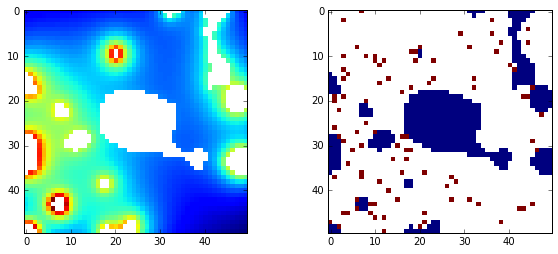

In [18]:
gamma = 1 + 2 * np.random.rand(len(m.dists))
alpha = np.random.rand(len(m.dists))
# alpha = np.sqrt([m.clusters[i+1].shape[0] for i in range(len(m.clusters))])

M = m.density(alpha, gamma)

fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(121)

ax1.imshow(np.log(M), interpolation = 'nearest')

ax2 = fig.add_subplot(122)
M1 = m.sample(n_samples = 100, alpha = alpha, gamma = gamma)
to_viz = (M1 - m.M0)*2
to_viz[np.isnan(M)] = 1
to_viz[to_viz == 0] = np.nan
ax2.imshow(to_viz, interpolation = 'nearest')

In [19]:
alpha_prime = np.random.rand(len(alpha))
gamma_prime = 1 + 2 * np.random.rand(len(gamma))

v1 = m.log_likelihood(M1, alpha = alpha,       gamma = gamma, normalized = True)
v2 = m.log_likelihood(M1, alpha = alpha_prime, gamma = gamma, normalized = True)
v3 = m.log_likelihood(M1, alpha = alpha,       gamma = gamma_prime, normalized = True)
v4 = m.log_likelihood(M1, alpha = alpha_prime, gamma = gamma_prime, normalized = True)

np.round(np.array([v1, v2, v3, v4]), 3)

array([-7.396, -7.427, -7.442, -7.503])

Conjecture: there are going to be some parameters about which the model is highly uncertain, and others about which it is quite confident. 

In [25]:
alpha_prime = np.random.rand(len(alpha))
gamma_prime = 1 + 2 * np.random.rand(len(gamma))

X = M1 - m.M0
alpha_hat, gamma_hat, lik = m.EM(M1, 
                            alpha_prime, 
                            gamma_prime, 
                            verbose = True,
                            n_iters = 10, 
                            tol = .001,
                            eta = .01, 
                            n_inner = 20,
                            inner_tol = .01)

ll0 : -7.5
ll  : -7.44
ll  : -7.42
ll  : -7.42
ll  : -7.41
ll  : -7.41
ll  : -7.4
ll  : -7.4
ll  : -7.4
ll  : -7.4
ll  : -7.39


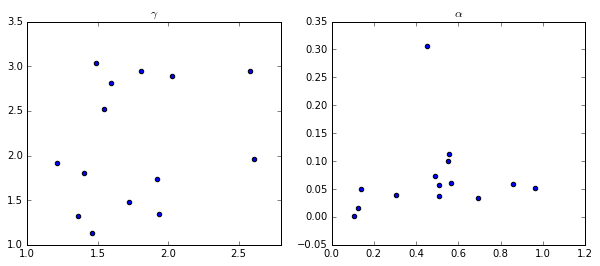

In [26]:
fig = plt.figure(figsize = (10, 4))
ax1 = fig.add_subplot(121)
ax1.scatter(gamma, gamma_hat)
plt.title(r'$\gamma$')

ax2 = fig.add_subplot(122)
ax2.scatter(alpha, alpha_hat)
plt.title(r'$\alpha$')

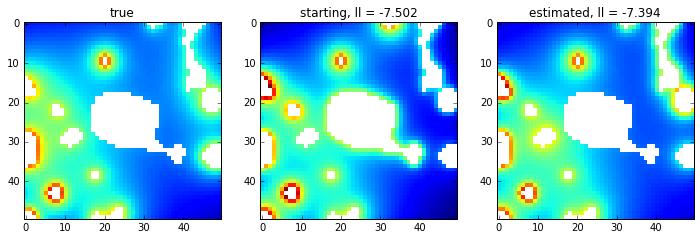

In [27]:
fig = plt.figure(figsize = (12, 5))

d0 = np.log(m.density(alpha, gamma))
d1 = np.log(m.density(alpha_prime, gamma_prime))
d2 = np.log(m.density(alpha_hat, gamma_hat))

lik_initial = m.log_likelihood(M1, 
                               alpha = alpha_prime, 
                               gamma = gamma_prime, 
                               normalized = True)

vmax, vmin = np.nanmax((d0, d1, d2)), np.nanmin((d0, d1, d2))

ax1 = fig.add_subplot(131)
ax1.imshow(d0, interpolation = 'nearest', vmax = vmax, vmin = vmin)
plt.title('true')

ax2 = fig.add_subplot(132)
ax2.imshow(d1, interpolation = 'nearest', vmax = vmax, vmin = vmin)
plt.title('starting, ll = ' + str(np.round(lik_initial, 3)))

ax3 = fig.add_subplot(133)
ax3.imshow(d2, interpolation = 'nearest', vmax = vmax, vmin = vmin)
plt.title('estimated, ll = ' + str(np.round(lik, 3)))